In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

SAVE_MODELS = False

# Load Data

In [2]:
data_train_1 = pickle.load(open("data/data_train_flatten_batch_1.pkl", "rb"))
data_train_2 = pickle.load(open("data/data_train_flatten_batch_2.pkl", "rb"))
labels_train_1 = pickle.load(open("data/labels_train_batch_1.pkl", "rb"))
labels_train_2 = pickle.load(open("data/labels_train_batch_2.pkl", "rb"))

In [3]:
data_train = np.concatenate((data_train_1, data_train_2))
labels_train = np.concatenate((labels_train_1, labels_train_2))

In [4]:
data_test = pickle.load(open("data/data_test_flatten.pkl", "rb"))
labels_test = pickle.load(open("data/labels_test.pkl", "rb"))

In [5]:
# Shuffle train set
data_train, labels_train = shuffle(data_train, labels_train, random_state=25)

# Scale Data

In [6]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(data_train)
X_test_std = scaler.transform(data_test)

# Train Model

In [7]:
# Create custom scorer for tuning
def f1_global(y_true, y_pred):
    precision_macro = precision_score(y_true, y_pred, average="macro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    return (2 * precision_macro * recall_macro) / (precision_macro + recall_macro)

f1_global_scorer = make_scorer(f1_global, greater_is_better=True)


m = LogisticRegression(n_jobs=-1)

parameters = [
    {
        "solver": ["lbfgs"],
        "penalty": [None, "l2"],
        "multi_class": ["multinomial", "ovr"]
    },
    {
        "solver": ["saga"],
        "penalty": ["l1", "elasticnet"],
        "multi_class": ["multinomial", "ovr"]
    }
]

grid_search = GridSearchCV(m, parameters, verbose=3, scoring=f1_global_scorer)
grid_search.fit(X_train_std, labels_train)
model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END multi_class=multinomial, penalty=None, solver=lbfgs;, score=nan total time=   0.6s
[CV 2/5] END multi_class=multinomial, penalty=None, solver=lbfgs;, score=nan total time=   0.6s
[CV 3/5] END multi_class=multinomial, penalty=None, solver=lbfgs;, score=nan total time=   0.6s
[CV 4/5] END multi_class=multinomial, penalty=None, solver=lbfgs;, score=nan total time=   0.6s
[CV 5/5] END multi_class=multinomial, penalty=None, solver=lbfgs;, score=nan total time=   0.6s
[CV 1/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.393 total time= 3.3min
[CV 2/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.390 total time= 2.3min
[CV 3/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.390 total time= 1.6min
[CV 4/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.394 total time= 1.6min
[CV 5/5] END multi_class=multinomial, penalty=l2, solver=lbfgs;, score=0.393

In [8]:
print("Model optimal parameters".upper())
print("solver:", model.get_params()["solver"])
print("penalty:", model.get_params()["penalty"])
print("multi_class:", model.get_params()["multi_class"])

MODEL OPTIMAL PARAMETERS
solver: lbfgs
penalty: l2
multi_class: multinomial


# Test Model

In [9]:
predictions = model.predict(X_test_std)

accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions, average="macro")
recall = recall_score(labels_test, predictions, average="macro")
f1_macro = f1_score(labels_test, predictions, average="macro")
f1_glob = (2 * precision * recall) / (precision + recall)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy*100,precision*100,recall*100))
print("\nF1 macro: {:.4f}%\nF1 global: {:.4f}%".format(f1_macro*100, f1_glob*100))

Accuracy score: 39.7900%
Precision macro: 39.5960%
Recall macro: 39.7900%

F1 macro: 39.6352%
F1 global: 39.6928%


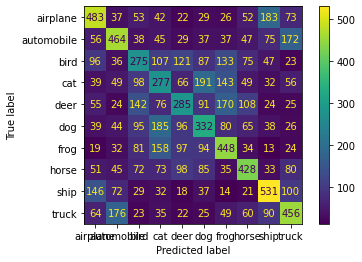

In [10]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Save Model

In [11]:
if SAVE_MODELS:
    model_file_name = "lr.pkl"
    pickle.dump(model, open(model_file_name, "wb"))

# Black And White

## Load data

In [12]:
train_batches = []
labels_batches = []

for i in [1, 2, 3, 4, 5]:
    data_filepath = "data/data_train_bw_flatten_batch_" + str(i) + ".pkl"
    labels_filepath = "data/labels_train_bw_batch_" + str(i) + ".pkl"
    train_batches.append(pickle.load(open(data_filepath, "rb")))
    labels_batches.append(pickle.load(open(labels_filepath, "rb")))
    
data_train_bw = np.concatenate(train_batches)
labels_train_bw = np.concatenate(labels_batches)

data_test_bw = pickle.load(open("data/data_test_bw_flatten.pkl", "rb"))
labels_test_bw = pickle.load(open("data/labels_test_bw.pkl", "rb"))

# Shuffle train set
data_train_bw, labels_train_bw = shuffle(data_train_bw, labels_train_bw, random_state=25)

## Scale data

In [13]:
scaler = StandardScaler()

X_train_std_bw = scaler.fit_transform(data_train_bw)
X_test_std_bw = scaler.transform(data_test_bw)

## Train model

In [14]:
m = LogisticRegression()

parameters = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "multi_class": ["multinomial", "ovr"]
    },
    {
        "solver": ["saga"],
        "penalty": [None, "l1", "elasticnet"],
        "multi_class": ["multinomial", "ovr"]
    }
]


grid_search = GridSearchCV(m, parameters, verbose=3, scoring=f1_global_scorer, n_jobs=2)
grid_search.fit(X_train_std_bw, labels_train_bw)
model_bw = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [15]:
print("Model optimal parameters".upper())
print("solver:", model_bw.get_params()["solver"])
print("penalty:", model_bw.get_params()["penalty"])
print("multi_class:", model_bw.get_params()["multi_class"])

MODEL OPTIMAL PARAMETERS
solver: saga
penalty: l1
multi_class: multinomial


## Test model

In [16]:
predictions_bw = model_bw.predict(X_test_std_bw)

accuracy_bw = accuracy_score(labels_test_bw, predictions_bw)
precision_bw = precision_score(labels_test_bw, predictions_bw, average="macro")
recall_bw = recall_score(labels_test_bw, predictions_bw, average="macro")
f1_macro_bw = f1_score(labels_test_bw, predictions_bw, average="macro")
f1_glob_bw = (2 * precision_bw * recall_bw) / (precision_bw + recall_bw)

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%".format(accuracy_bw*100,precision_bw*100,recall_bw*100))
print("F1 macro: {:.4f}%\nF1 global: {:.4f}".format(f1_macro_bw*100, f1_glob_bw*100))

Accuracy score: 27.7900%
Precision macro: 27.2098%
Recall macro: 27.7900%
F1 macro: 27.3981%
F1 global: 27.4968


[]

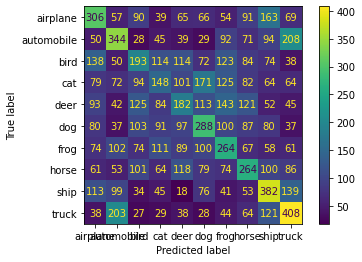

In [17]:
cm = confusion_matrix(labels_test_bw, predictions_bw, labels=model_bw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bw.classes_)
disp.plot()
plt.plot()

## Save model

In [18]:
if SAVE_MODELS:
    model_file_name_bw = "lr_bw.pkl"
    pickle.dump(model_bw, open(model_file_name_bw, "wb"))